**Data Preprocessing**


In [2]:
# Data management
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Import for normalization
from sklearn.preprocessing import MinMaxScaler

# Import chi2 function 
from sklearn.feature_selection import chi2
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder    

print('Imports complete.')

Imports complete.


**Upload Data from Google Drive.**

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
ls

drive/  sample_data/


In [6]:
l1doh = pd.read_excel('/content/drive/My Drive/PhD/Afza/Jahangirnagar/2013/New_conference/CIRA-CIC-DoHBrw-2020/Total-CSVs/l1-doh.xlsx', sheet_name='l1-doh')

In [7]:
l1nondoh = pd.read_excel('/content/drive/My Drive/PhD/Afza/Jahangirnagar/2013/New_conference/CIRA-CIC-DoHBrw-2020/Total-CSVs/l1-nondoh.xlsx', sheet_name='l1-nondoh')

In [8]:
l2benign = pd.read_excel('/content/drive/My Drive/PhD/Afza/Jahangirnagar/2013/New_conference/CIRA-CIC-DoHBrw-2020/Total-CSVs/l2-benign.xlsx', sheet_name='l2-benign')

In [9]:
l2malicious = pd.read_excel('/content/drive/MyDrive/PhD/Afza/Jahangirnagar/2013/New_conference/CIRA-CIC-DoHBrw-2020/Total-CSVs/l2-malicious.xlsx', sheet_name='l2-malicious')

In [10]:
leb2 = 'Label'
l1doh[leb2].value_counts()

DoH    269643
Name: Label, dtype: int64

In [11]:
l1nondoh[leb2].value_counts()

NonDoH    897493
Name: Label, dtype: int64

In [12]:
l2benign[leb2].value_counts()

Benign    19807
Name: Label, dtype: int64

In [13]:
l2malicious[leb2].value_counts()

Malicious    249836
Name: Label, dtype: int64

In [14]:
print('Data read:')
l1doh.head()

Data read:


,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,PacketLengthSkewFromMedian,PacketLengthSkewFromMode,PacketLengthCoefficientofVariation,PacketTimeVariance,PacketTimeStandardDeviation,PacketTimeMean,PacketTimeMedian,PacketTimeMode,PacketTimeSkewFromMedian,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,687.388878,7474.676771,86.456213,135.673751,102.0,54,1.168467,0.944683,0.637236,670.585814,25.895672,45.065277,48.811292,1.495060,-0.433974,1.682529,0.574626,0.001053,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,DoH
1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,827.672018,10458.118598,102.264943,141.245474,114.0,54,0.799261,0.853132,0.724023,708.465878,26.617022,52.287903,48.830314,31.719656,0.389704,0.772748,0.509047,0.001170,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,DoH
2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,316.108645,7300.293933,85.441758,133.715278,89.0,54,1.570027,0.932978,0.638983,1358.911235,36.863413,50.316114,39.770747,0.417528,0.858198,1.353607,0.732636,0.000785,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,DoH
3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,631.278898,8499.282518,92.191553,139.123548,114.0,54,0.817544,0.923333,0.662660,1118.135436,33.438532,51.693726,34.882495,13.280934,1.508251,1.148758,0.646859,0.000411,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,DoH
4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,1416.266907,8052.745751,89.737092,138.913420,114.0,114,0.832880,0.277627,0.645993,341.696613,18.485038,36.435619,49.822561,7.342519,-2.172613,1.573873,0.507334,0.079079,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,DoH


In [15]:
print('Table Information:')
l1doh.info()

Table Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269643 entries, 0 to 269642
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   SourceIP                                269643 non-null  object        
 1   DestinationIP                           269643 non-null  object        
 2   SourcePort                              269643 non-null  int64         
 3   DestinationPort                         269643 non-null  int64         
 4   TimeStamp                               269643 non-null  datetime64[ns]
 5   Duration                                269643 non-null  float64       
 6   FlowBytesSent                           269643 non-null  int64         
 7   FlowSentRate                            269643 non-null  float64       
 8   FlowBytesReceived                       269643 non-null  int64         
 9   FlowReceivedRate  

Great! Let's verify that the columns are the same in each dataframe.



In [16]:
cols0 = l1doh.columns
cols1 = l1nondoh.columns

mismatch = False

for col in cols0:
    if col not in cols1:
        print('column missing from l1-doh: {}')
        mismatch = True
        
for col in cols1:
    if col not in cols0:
        print('column missing from l1-nondoh: {}')
        mismatch = True
        
if not mismatch:
    print('All columns match up!')

All columns match up!


In [17]:
cols0 = l2benign.columns
cols1 = l2malicious.columns
mismatch = False

for col in cols0:
    if col not in cols1:
        print('column missing from l2-benign: {}')
        mismatch = True
        
for col in cols1:
    if col not in cols0:
        print('column missing from l2-malicious: {}')
        mismatch = True
        
if not mismatch:
    print('All columns match up!')

All columns match up!


Now, let's bring these separate dataframes into the same dataframe.



In [18]:
df = pd.concat([l1doh, l1nondoh, l2benign, l2malicious])
df[leb2].value_counts()

NonDoH       897493
DoH          269643
Malicious    249836
Benign        19807
Name: Label, dtype: int64

In [19]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,PacketLengthSkewFromMedian,PacketLengthSkewFromMode,PacketLengthCoefficientofVariation,PacketTimeVariance,PacketTimeStandardDeviation,PacketTimeMean,PacketTimeMedian,PacketTimeMode,PacketTimeSkewFromMedian,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:49:11,95.081550,62311,655.342703,65358,687.388878,7474.676771,86.456213,135.673751,102.0,54,1.168467,0.944683,0.637236,670.585814,25.895672,45.065277,48.811292,1.495060,-0.433974,1.682529,0.574626,0.001053,0.032457,0.027624,0.026854,0.026822,0.071187,0.024715,1.174948,DoH
1,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:50:52,122.309318,93828,767.136973,101232,827.672018,10458.118598,102.264943,141.245474,114.0,54,0.799261,0.853132,0.724023,708.465878,26.617022,52.287903,48.830314,31.719656,0.389704,0.772748,0.509047,0.001170,0.034200,0.024387,0.021043,0.026981,0.293297,-0.075845,1.402382,DoH
2,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:52:55,120.958413,38784,320.639127,38236,316.108645,7300.293933,85.441758,133.715278,89.0,54,1.570027,0.932978,0.638983,1358.911235,36.863413,50.316114,39.770747,0.417528,0.858198,1.353607,0.732636,0.000785,0.028021,0.029238,0.026922,0.026855,0.248064,0.085061,0.958348,DoH
3,192.168.20.191,176.103.130.131,50749,443,2020-01-14 15:54:56,110.501080,61993,561.017141,69757,631.278898,8499.282518,92.191553,139.123548,114.0,54,0.817544,0.923333,0.662660,1118.135436,33.438532,51.693726,34.882495,13.280934,1.508251,1.148758,0.646859,0.000411,0.020274,0.019925,0.019268,0.026918,0.097199,-0.344926,1.017535,DoH
4,176.103.130.131,192.168.20.191,443,50749,2020-01-14 15:56:46,54.229891,83641,1542.341289,76804,1416.266907,8052.745751,89.737092,138.913420,114.0,114,0.832880,0.277627,0.645993,341.696613,18.485038,36.435619,49.822561,7.342519,-2.172613,1.573873,0.507334,0.079079,0.281209,0.025930,0.000046,0.000021,0.276133,0.092135,10.844829,DoH


Now, we need to sort out all of the nan values from the dataset.

In [20]:
print('There are {} columns and {} rows in the provided data.'.format(len(df.columns), len(df)))

There are 35 columns and 1436779 rows in the provided data.


In [21]:
df.dropna(axis='index', inplace=True)

In [22]:
print('There are {} columns and {} rows in the provided data.'.format(len(df.columns), len(df)))

There are 35 columns and 1428407 rows in the provided data.


We need to remove some columns because they contain data types that would overfit the models, such as SourceIP.

In [20]:
bad_columns = ['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp']
df.drop(labels=bad_columns, axis='columns', inplace=True)

In [27]:
# The target classifications are in the 'Label' columns, 
#  thus this is the independent variable!
df[leb2].value_counts()

NonDoH       897493
DoH          269643
Malicious    249836
Benign        19807
Name: Label, dtype: int64

In [28]:
# Split up the data into the data (X) and classifications (y)
X = df.loc[:, df.columns != leb2]
y = df[leb2]

In [29]:
# We need to normalize X so we don't have negative values. 
#  Chi-squared doesn't like negative values!
scaler = MinMaxScaler()
X = pd.DataFrame( 
    scaler.fit_transform(X), 
    columns=X.columns 
)

In [30]:
# Additions of another work found here: https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223
chi_scores = chi2(X, y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = True , inplace = True)
#p_values.plot.bar()
print('Values in order of ascending p-values (lower=more significant)')
print(p_values)
for i in range(len(p_values)):
    print('| {} | {} | {} |'.format(i, p_values.index[i], p_values[i]))

ValueError: ignored

In [31]:
print(p_values.index)

NameError: ignored

In [29]:
# This is the ordered list of features from lowest p-value to highest p-value (best to worst)
#  acquired from the 'chi2_feature_selection' notebook
data_cols = [
    'Duration', 
    'ResponseTimeTimeSkewFromMedian', 
    'ResponseTimeTimeMode',
    'ResponseTimeTimeMedian', 
    'ResponseTimeTimeMean',
    'PacketTimeSkewFromMedian', 
    'PacketTimeMode', 
    'PacketTimeMedian',
    'PacketTimeMean', 
    'ResponseTimeTimeSkewFromMode'
]
target_col = 'Label'

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

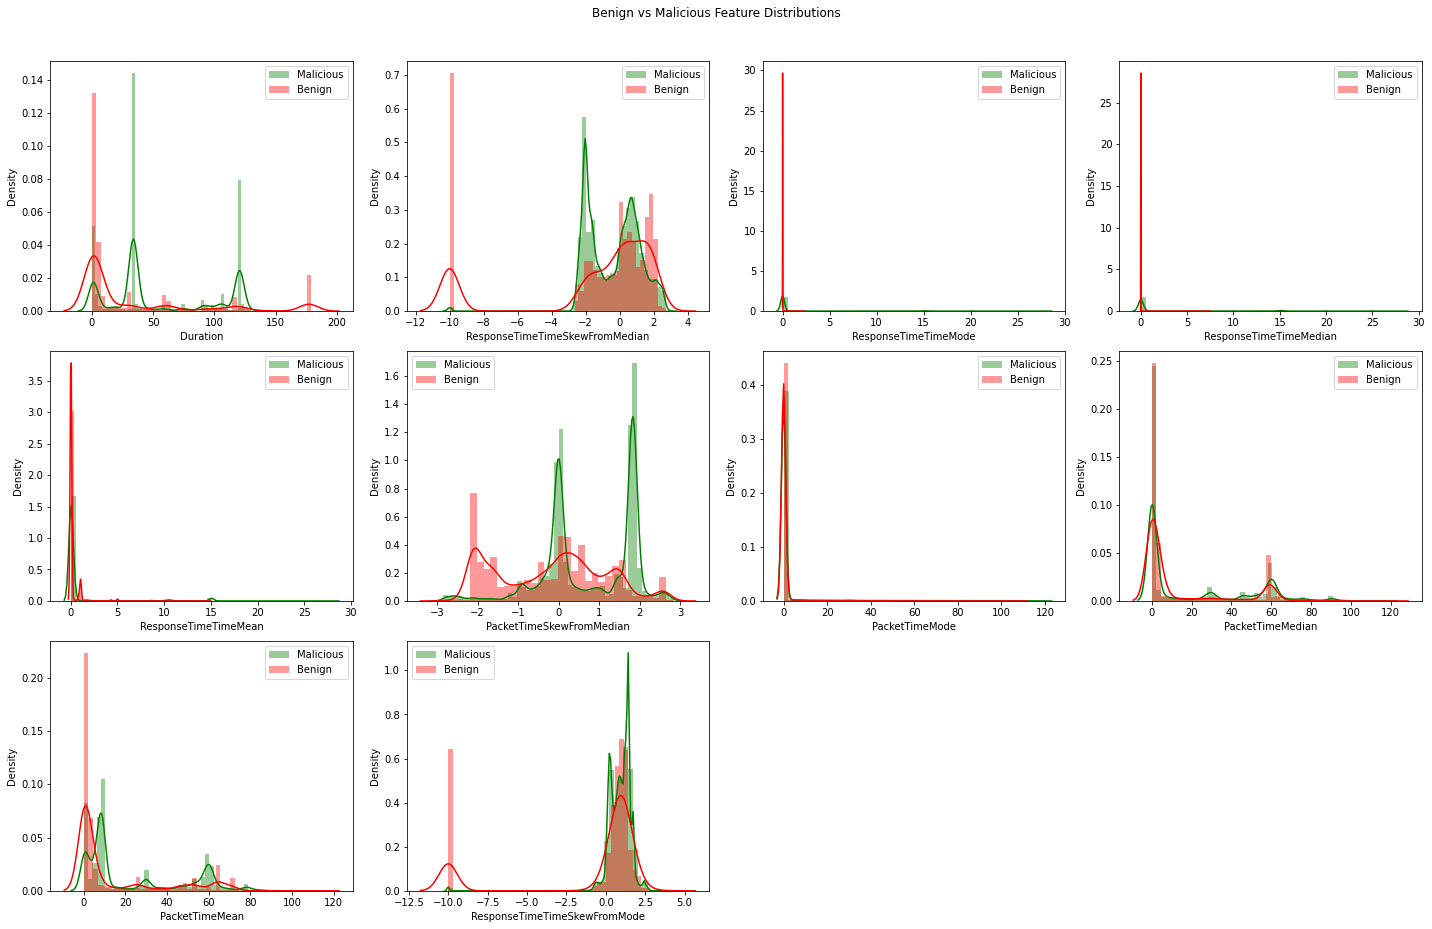

In [30]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_cols:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df[i][df[target_col]=='Malicious'], color='g', label = 'Malicious')
    sns.distplot(df[i][df[target_col]=='Benign'], color='r', label = 'Benign')
    plt.legend(loc='best')
fig.suptitle('Benign vs Malicious Feature Distributions')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Prepare data for training the RNN models

In [32]:
def load_data(df, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)):
        X_train.append(df.iloc[i-seq_len : i, 0])
        y_train.append(df.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [33]:
#create train, test data

#choose sequence length
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (1326759, 20, 1)
y_test.shape =  (1326759,)


In [33]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [34]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 7s 67ms/step - loss: 4406.4082
Epoch 2/10
110/110 [==============================] - 7s 65ms/step - loss: 3875.1631
Epoch 3/10
110/110 [==============================] - 7s 65ms/step - loss: 3547.5366
Epoch 4/10
110/110 [==============================] - 7s 65ms/step - loss: 3250.0134
Epoch 5/10
110/110 [==============================] - 7s 65ms/step - loss: 2986.0735
Epoch 6/10
110/110 [==============================] - 7s 65ms/step - loss: 2770.7422
Epoch 7/10
110/110 [==============================] - 7s 64ms/step - loss: 2584.5227
Epoch 8/10
110/110 [==============================] - 7s 65ms/step - loss: 2424.3992
Epoch 9/10
110/110 [==============================] - 7s 65ms/step - loss: 2295.6553
Epoch 10/10
110/110 [==============================] - 7s 65ms/step - loss: 2163.1960


In [35]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.46126430684825426


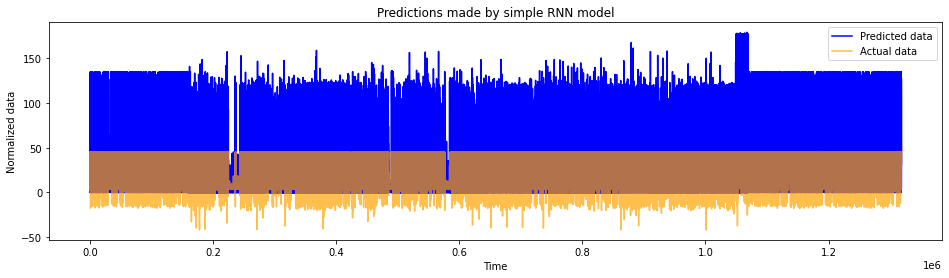

In [46]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Predicted data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Actual data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized data')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

Build an LSTM model

In [37]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [38]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 19s 177ms/step - loss: 4487.0518
Epoch 2/10
110/110 [==============================] - 19s 177ms/step - loss: 3891.0239
Epoch 3/10
110/110 [==============================] - 19s 176ms/step - loss: 3545.9524
Epoch 4/10
110/110 [==============================] - 20s 185ms/step - loss: 3220.1917
Epoch 5/10
110/110 [==============================] - 19s 176ms/step - loss: 2958.1704
Epoch 6/10
110/110 [==============================] - 19s 176ms/step - loss: 2737.2803
Epoch 7/10
110/110 [==============================] - 19s 177ms/step - loss: 2551.3457
Epoch 8/10
110/110 [==============================] - 19s 177ms/step - loss: 2388.1150
Epoch 9/10
110/110 [==============================] - 19s 176ms/step - loss: 2221.8130
Epoch 10/10
110/110 [==============================] - 19s 176ms/step - loss: 2061.2781


In [39]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.46581741502867524


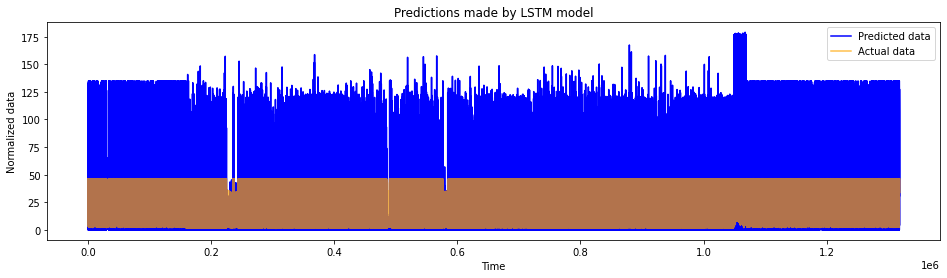

In [47]:
plot_predictions(y_test,lstm_predictions, "Predictions made by LSTM model")

Compare predictions made by simple RNN, LSTM model by plotting data in a single 

1.   List item
2.   List item

graph

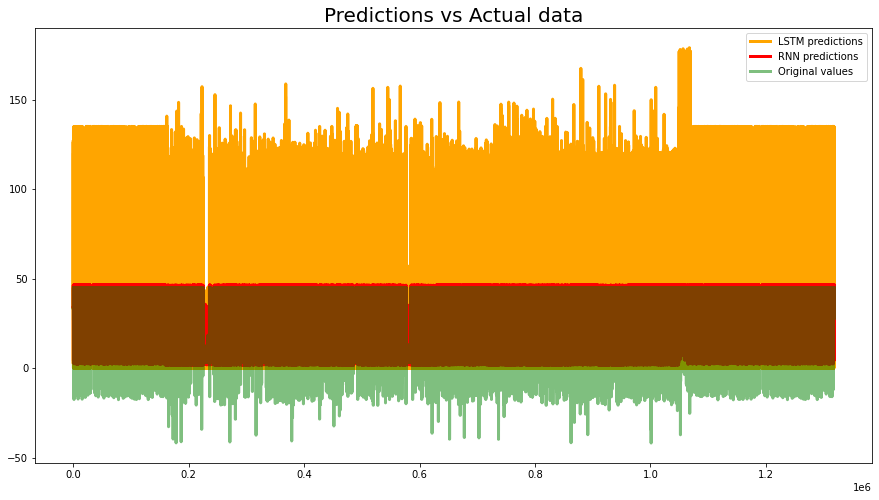

In [44]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="LSTM predictions")
plt.plot(lstm_predictions, c="red", linewidth=3, label="RNN predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="Original values")
plt.legend()
plt.title("Predictions vs Actual data", fontsize=20)
plt.show()

In [34]:
data = df.iloc[:,1:-1]

In [35]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [36]:
corr = data.corr()

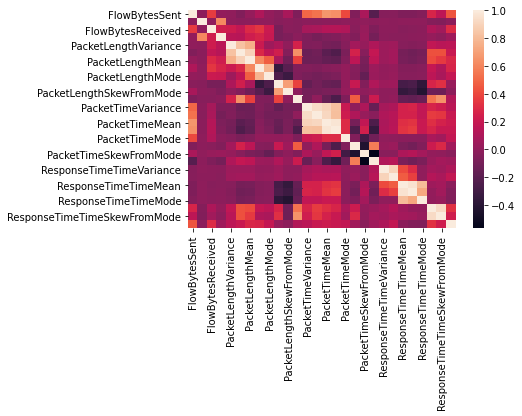

In [68]:
sns.heatmap(corr)

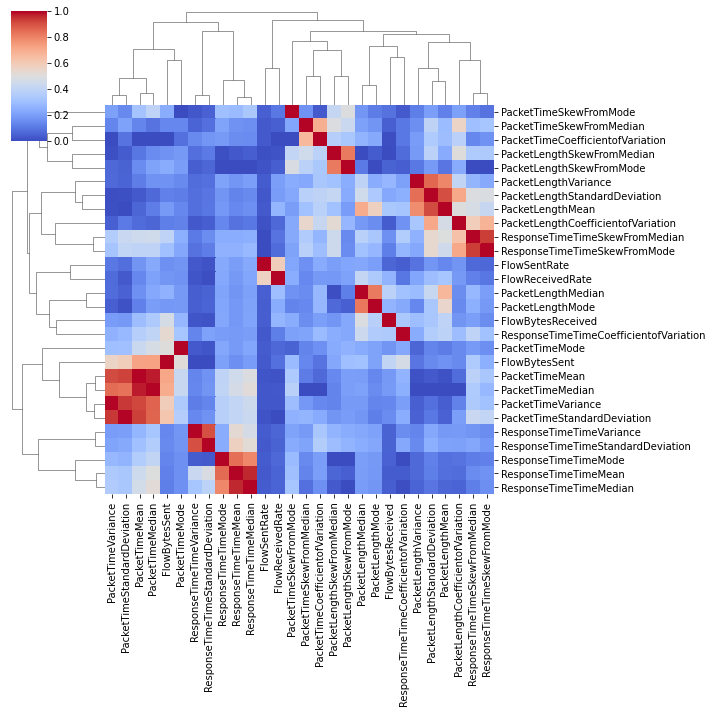

In [37]:
sns.clustermap(corr,cmap='coolwarm',standard_scale=1)

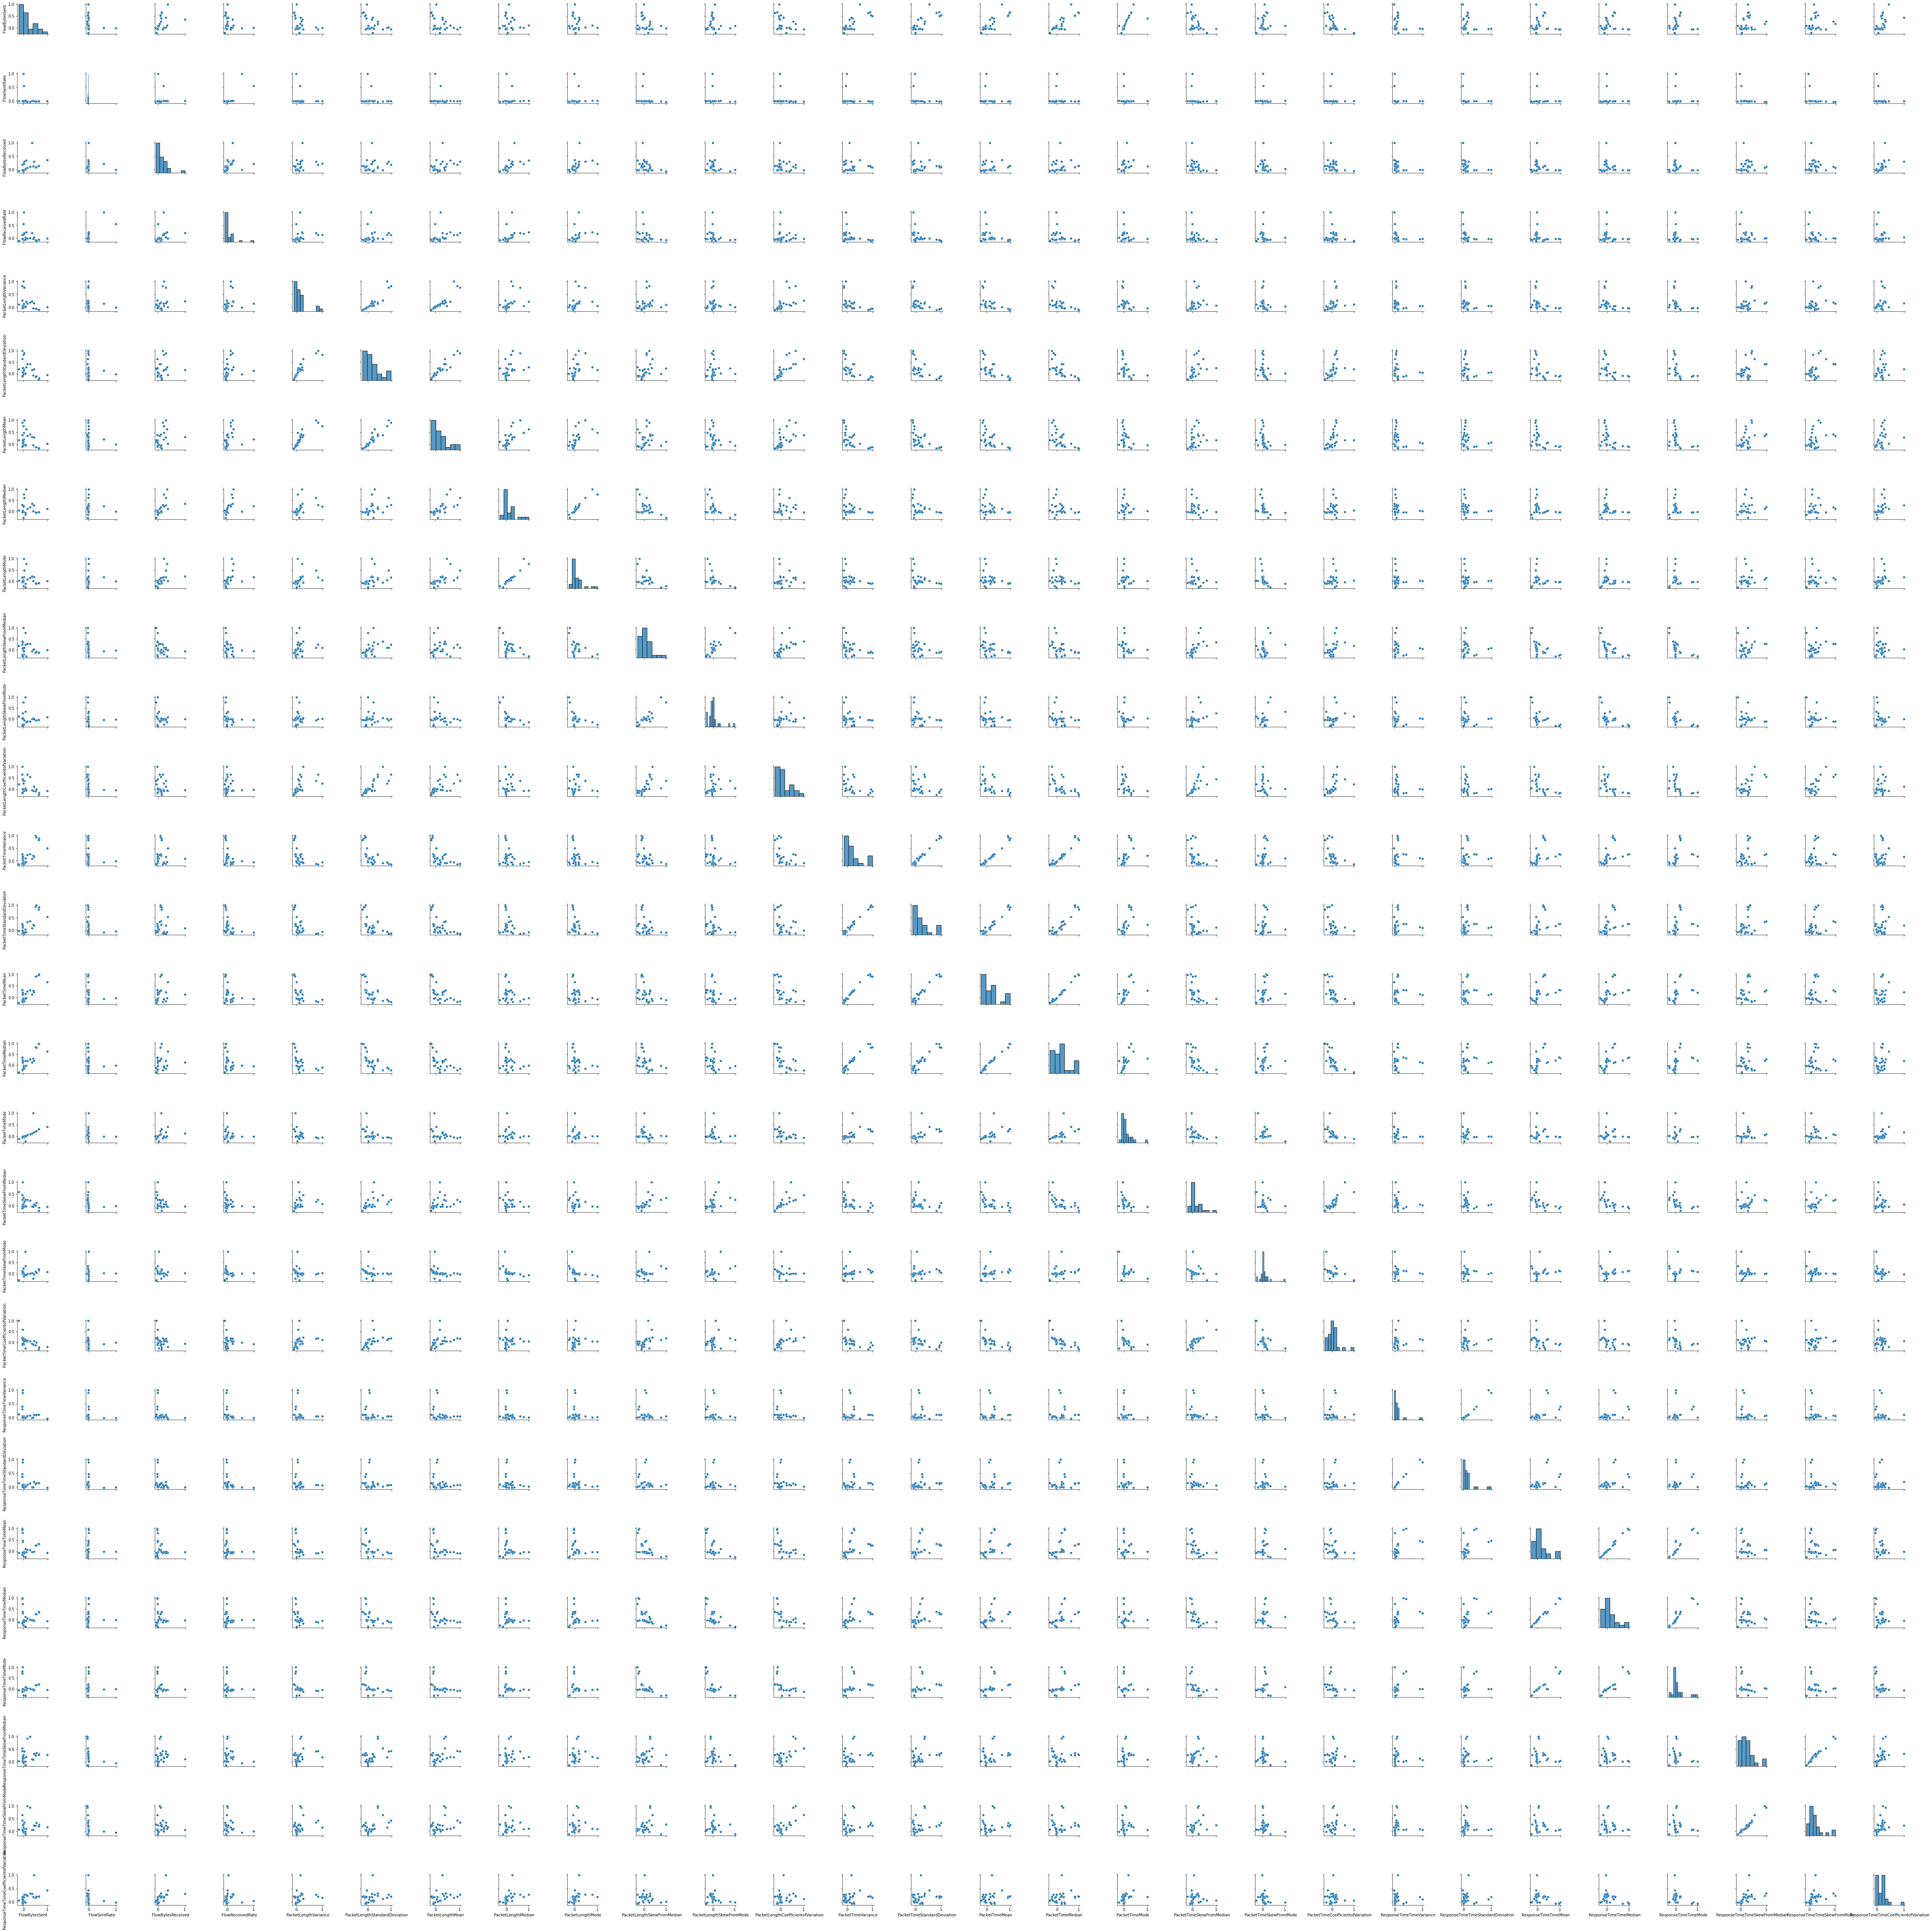

In [38]:
sns.pairplot(corr)

In [40]:
g = sns.PairGrid(corr)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.lineplot)

Output hidden; open in https://colab.research.google.com to view.